In [79]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import seaborn as sns
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score)
from wordcloud import WordCloud
import random
import re

from sklearn.model_selection import train_test_split


nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vokanev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/vokanev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# EDA

Setting seeds

In [80]:
seed = 42
random.seed(seed)
np.random.seed(seed)

Dataset was taken from https://www.kaggle.com/datasets/constantinwerner/multilingual-ner-dataset?select=rus.tsv and a bit processed manually. Sentences were separated with empty line. Instead of empty line <EOS> tag was placed.

In [81]:
def parse_dataset_to_sentences(path):
    sentences = []
    current = []
    tags = set()
    
    with open(path) as f:
        for line in f:
            if line.strip() == '<EOS>':
                sentences.append(current)
                current = []
                continue
            tags.add(line.split()[1])
            current.append(line.split())
        if len(current):
            sentences.append(current)
    return sentences, tags

In [82]:
parsed_data, tags = parse_dataset_to_sentences('data/rus.tsv')
tags

{'B-CARDINAL',
 'B-DATE',
 'B-EVENT',
 'B-FAC',
 'B-GPE',
 'B-LANGUAGE',
 'B-LOC',
 'B-MONEY',
 'B-NORP',
 'B-ORDINAL',
 'B-ORG',
 'B-PERCENT',
 'B-PERSON',
 'B-PRODUCT',
 'B-QUANTITY',
 'B-TIME',
 'B-WORK_OF_ART',
 'I-CARDINAL',
 'I-DATE',
 'I-EVENT',
 'I-FAC',
 'I-GPE',
 'I-LANGUAGE',
 'I-LOC',
 'I-MONEY',
 'I-NORP',
 'I-ORG',
 'I-PERCENT',
 'I-PERSON',
 'I-PRODUCT',
 'I-QUANTITY',
 'I-TIME',
 'I-WORK_OF_ART',
 'O'}

Tag description:
 - CARDINAL - Numerals that do not fall under another type
 - DATE - Absolute or relative dates or periods
 - EVENT - Named hurricanes, battles, wars, sports events, etc
 - FAC -Buildings, airports, highways, bridges, etc
 - GPE - Countries, cities, states
 - LANGUAGE - Any named language.
 - LOC - Non-GPE locations, mountain ranges, bodies of water
 - MONEY - Monetary values, including unit
 - NORP - Nationalities or religious or political groups
 - ORDINAL - “first”, “second”, etc.
 - ORG - Companies, agencies, institutions, etc
 - PERCENT - Percentage, including ”%“.
 - PERSON - People, including fictional
 - PRODUCT - Objects, vehicles, foods, etc. (Not services.)
 - QUANTITY - Measurements, as of weight or distance
 - TIME - Times smaller than a day
 - WORK_OF_ART - Titles of books, songs, etc
 - O - other (no named entity)

In [83]:
tts_ratio = 0.4
train, test = train_test_split(parsed_data, test_size=tts_ratio)
print(f'Train/test ratio -> {tts_ratio}\nTrain size -> {len(train)}\nTest size -> {len(test)}\nTotal size -> {len(train) + len(test)}')

Train/test ratio -> 0.4
Train size -> 794
Test size -> 530
Total size -> 1324


In [84]:
def get_quantity_per_tag(data, tags):
    labels = {label : 0 for label in tags}
    for sentence in data:
        for ent in sentence:
            labels[ent[1]] += 1
    return labels

In [85]:
train_distrib = get_quantity_per_tag(train, tags)
test_distrib = get_quantity_per_tag(test, tags)

In [86]:
train_distrib

{'B-WORK_OF_ART': 9,
 'I-WORK_OF_ART': 8,
 'I-PRODUCT': 2,
 'B-ORDINAL': 64,
 'B-EVENT': 9,
 'I-PERCENT': 15,
 'I-GPE': 39,
 'B-PERSON': 427,
 'B-PRODUCT': 7,
 'B-MONEY': 31,
 'B-DATE': 266,
 'B-QUANTITY': 13,
 'I-NORP': 0,
 'I-PERSON': 316,
 'I-DATE': 246,
 'B-FAC': 32,
 'B-CARDINAL': 147,
 'I-FAC': 17,
 'I-QUANTITY': 12,
 'B-NORP': 164,
 'B-LANGUAGE': 0,
 'I-LANGUAGE': 0,
 'B-LOC': 64,
 'I-LOC': 37,
 'B-ORG': 385,
 'I-TIME': 39,
 'I-MONEY': 67,
 'B-TIME': 34,
 'O': 14320,
 'I-EVENT': 15,
 'I-ORG': 203,
 'I-CARDINAL': 19,
 'B-PERCENT': 16,
 'B-GPE': 521}

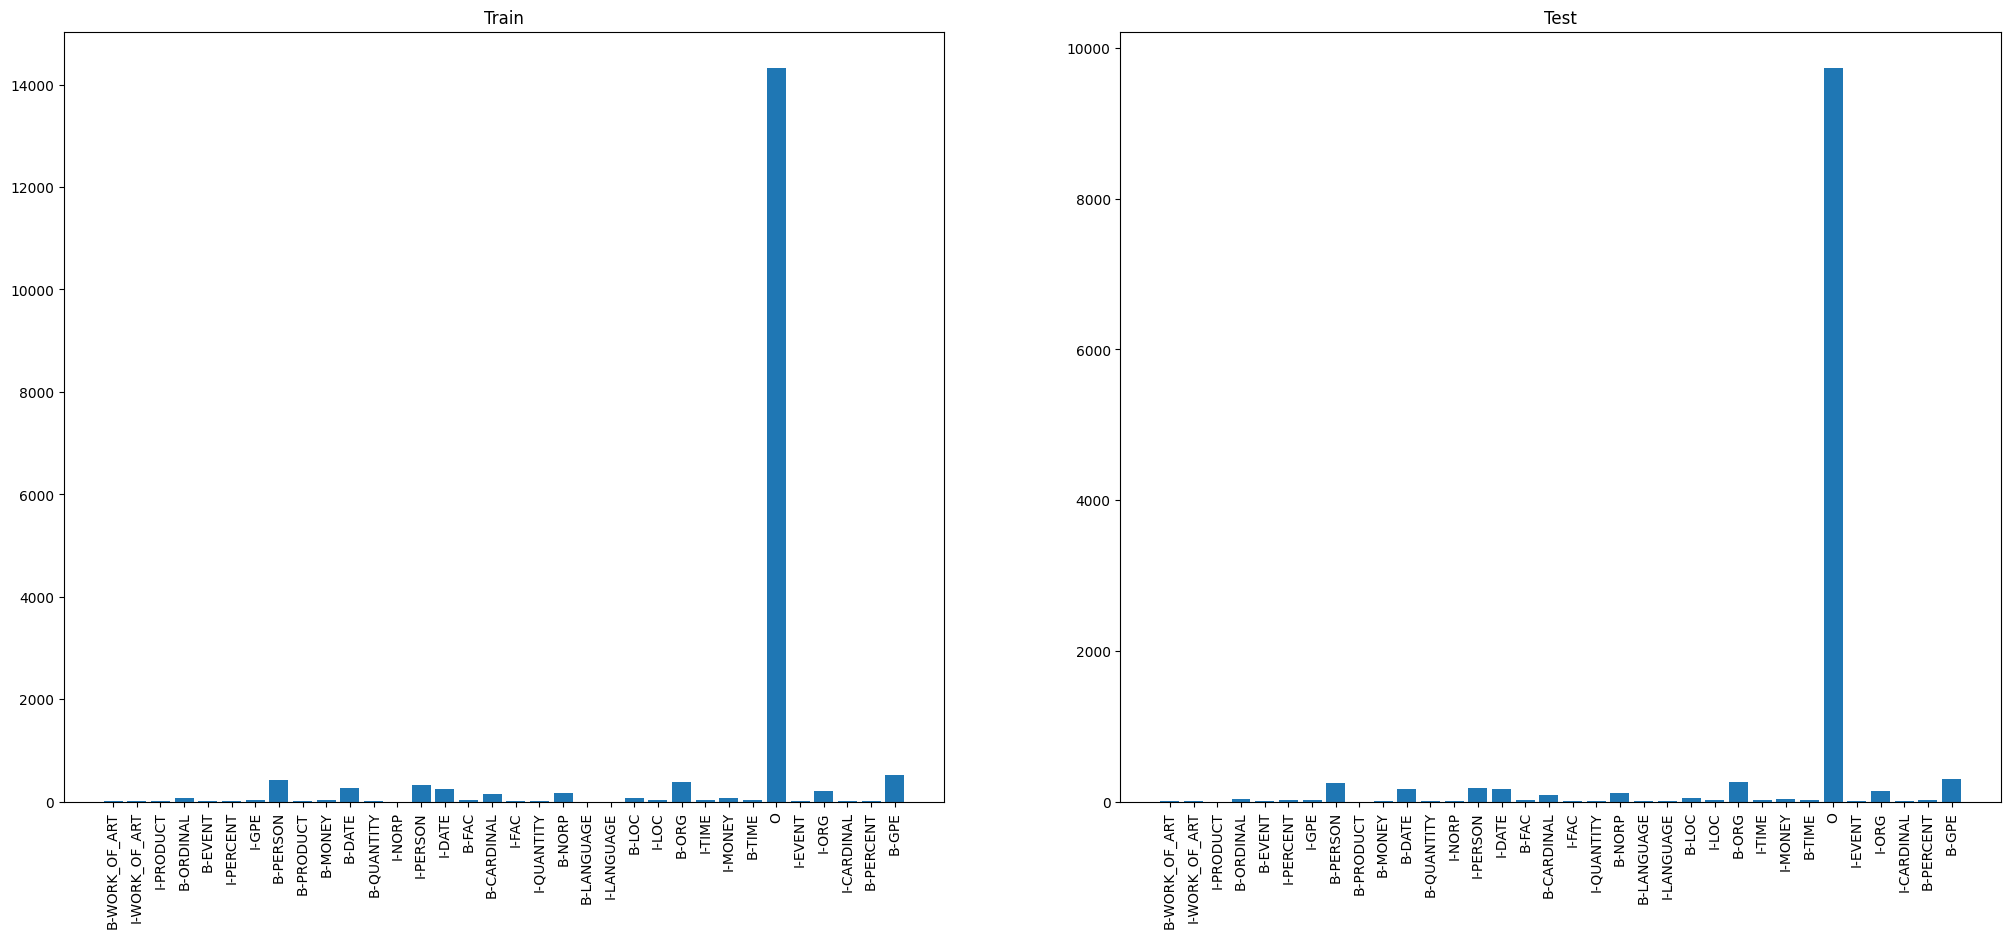

In [87]:
fig, axes = plt.subplots(1,2, figsize=(25,10))
datasets = [train_distrib, test_distrib]
titles = ['Train', 'Test']
for i, ax in enumerate(axes):
    ax.bar(
        x=list(datasets[i].keys()),
        height=list(datasets[i].values())
    )
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(titles[i])
plt.show()

Amount of 'o' (other) tags makes chart not informative. Let's exclude it to see labels distribution

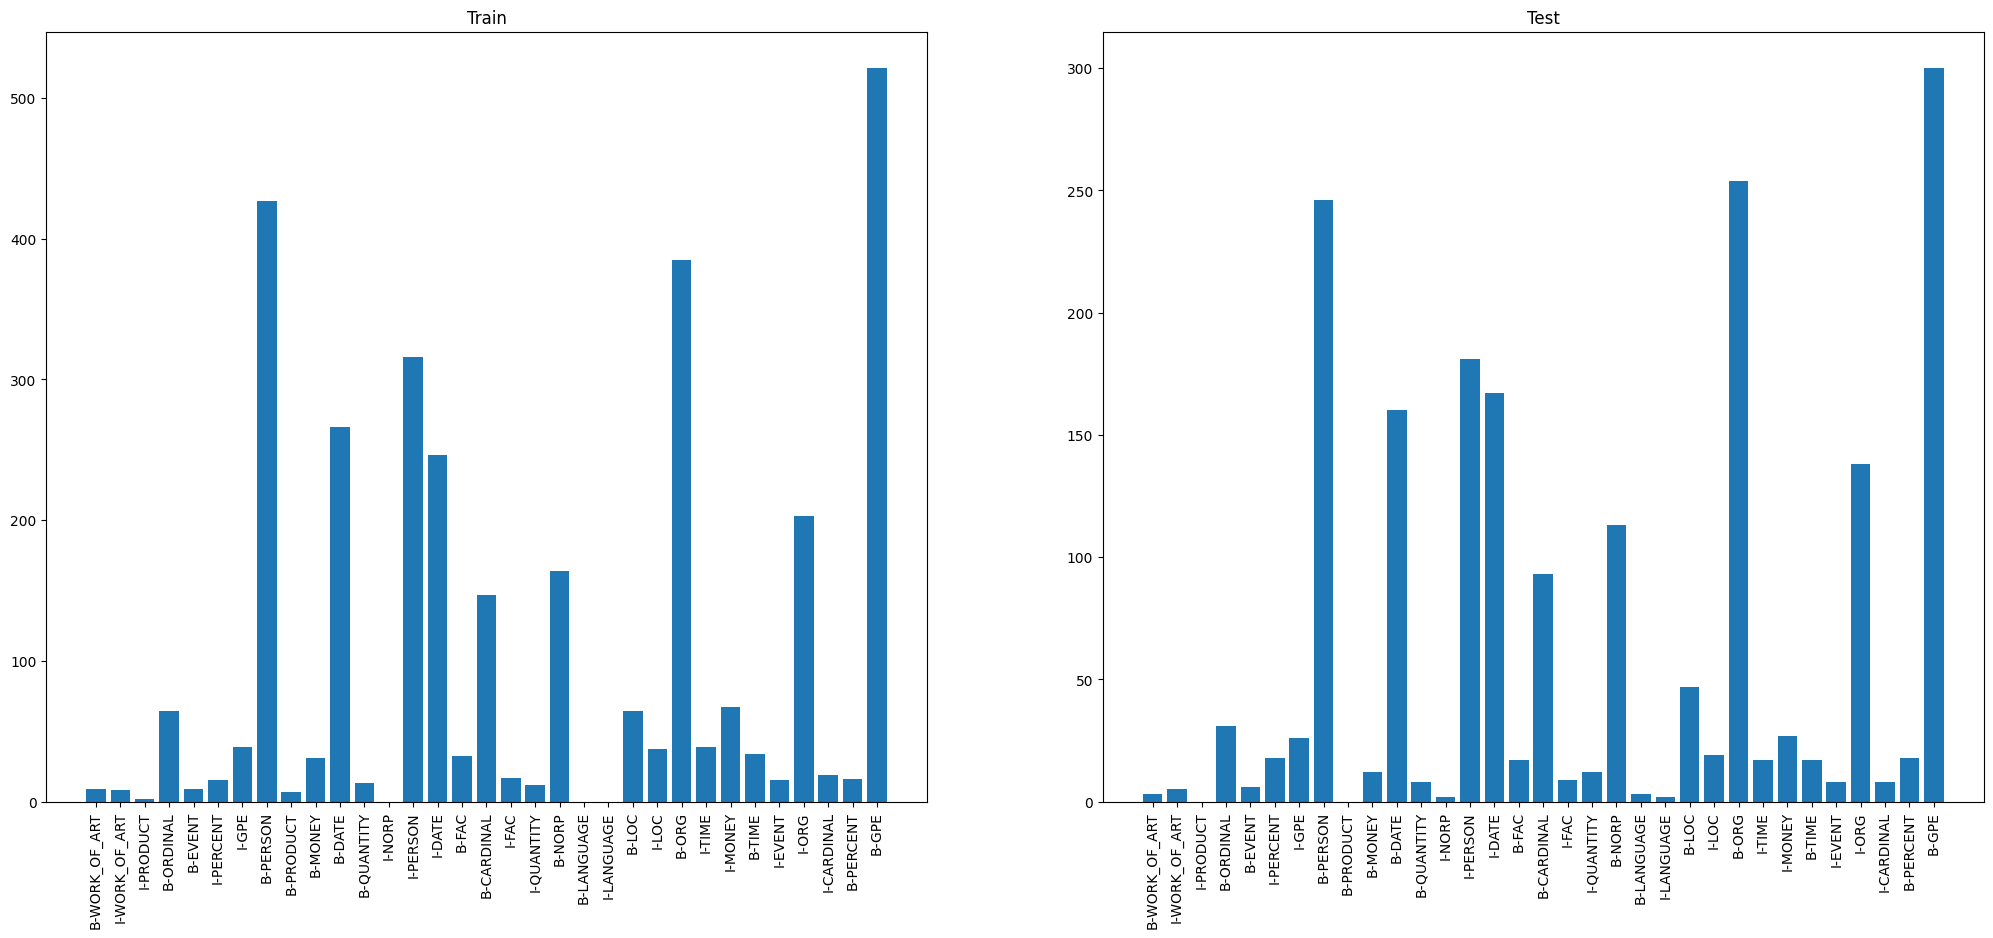

In [89]:
fig, axes = plt.subplots(1,2, figsize=(25,10))
train_distrib_named_only = train_distrib
test_distrib_named_only = test_distrib
if 'O' in train_distrib_named_only.keys():
    train_distrib_named_only.pop('O')
    test_distrib_named_only.pop('O')
datasets = [train_distrib_named_only,test_distrib_named_only]
titles = ['Train', 'Test']
for i, ax in enumerate(axes):
    ax.bar(
        x=list(datasets[i].keys()),
        height=list(datasets[i].values()),
        
    )
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(titles[i])
plt.show()

In both train and test subsets B-GPE, B-ORG, and B-PERSON took top-3 of all tags. I-LANGUAGE, I-NORP, and I-product took ending 3 places. It means that that usually 'language name', 'nationalities, religion...' and 'Objects, vehicles, foods, etc. (Not services.)' consist of no more than 2 words.

Other notable feature is that some tags facing in test dataset and not in train, like I-NORP, B-LANGUAGE and I-LANGUAGE. That will lead to decrease of model efficiency. To avoid the problem we should try to use stratified train_test_split.

In [36]:
df = pd.DataFrame([words for sentence in parsed_data for words in sentence], columns=["word", "tag"])
df.head()

,word,tag
0,Губернатору,O
1,Подмосковья,B-GPE
2,прочат,O
3,скорую,O
4,отставку,O


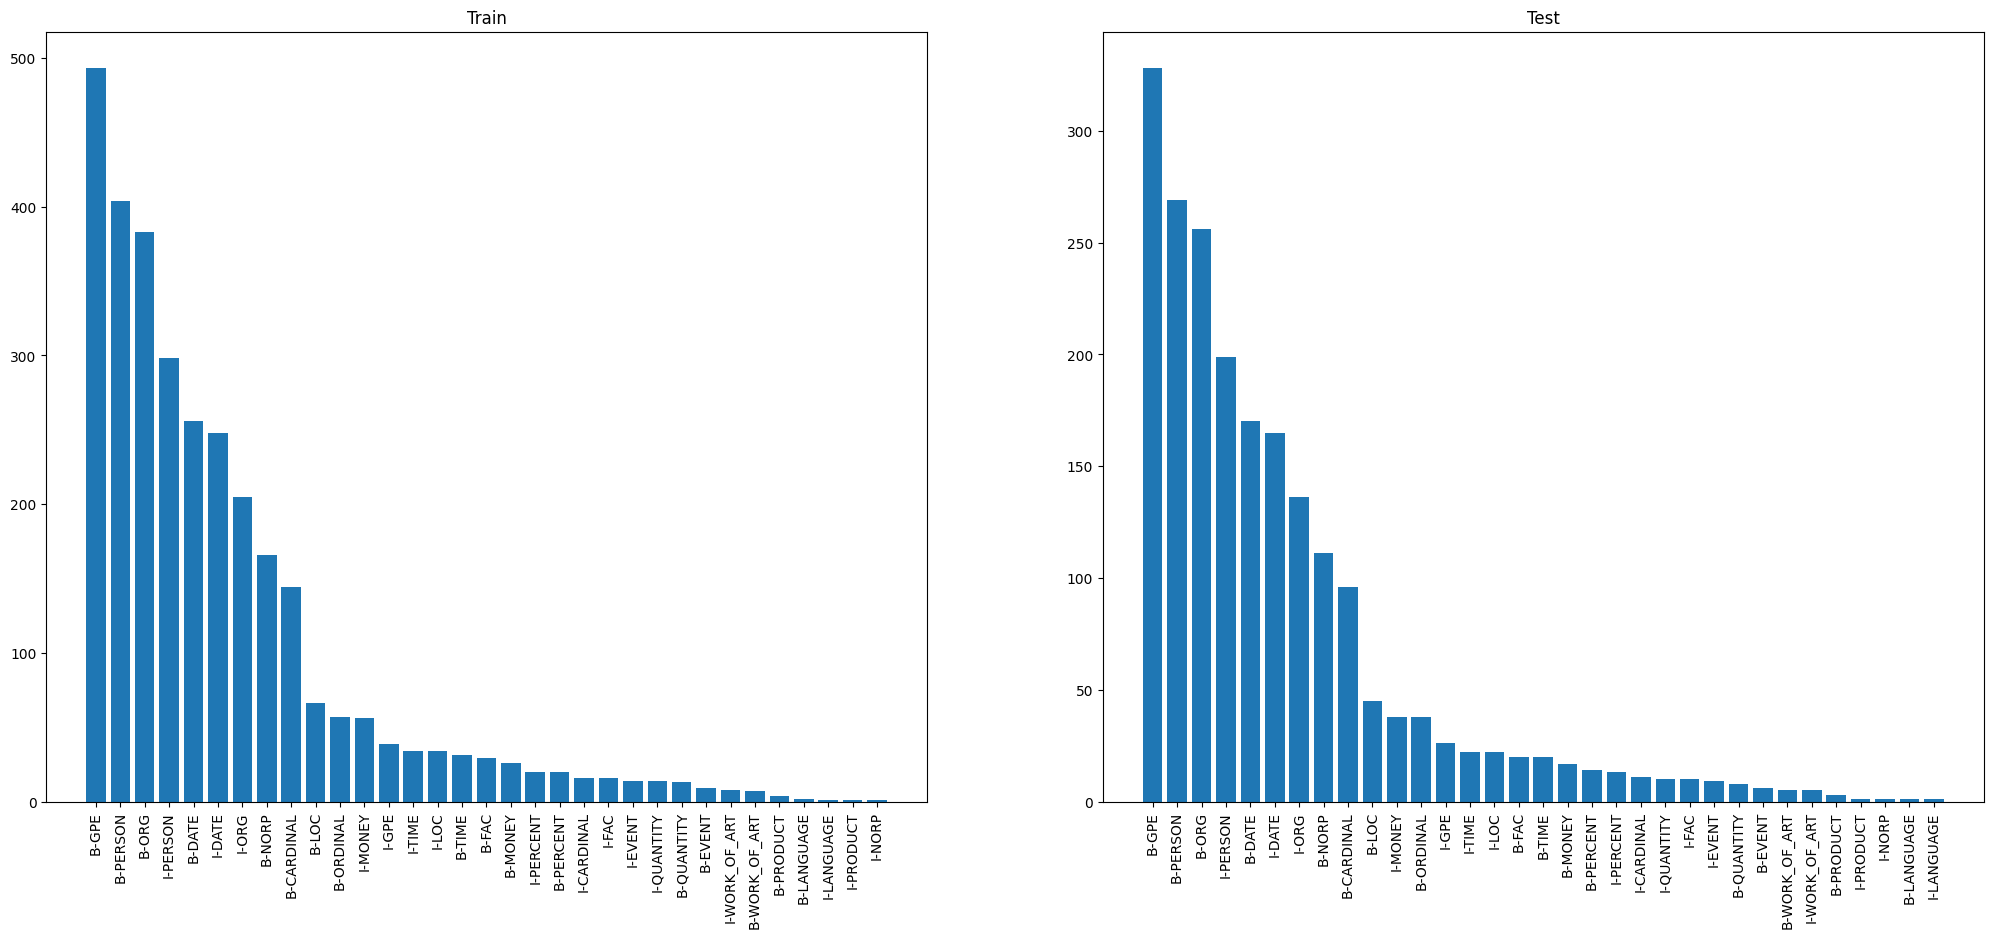

In [ ]:
train, test = train_test_split(df, test_size=tts_ratio, stratify=df['tag'])

fig, axes = plt.subplots(1,2, figsize=(25,10))

datasets = [train['tag'].value_counts().drop('O'), test['tag'].value_counts().drop('O')]
titles = ['Train', 'Test']
for i, ax in enumerate(axes):
    ax.bar(
        x=datasets[i].index,
        height=datasets[i].values,
    )
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(titles[i])
plt.show()

In [11]:
train_starts = {
    'CARDINAL' : {'B':0,'I':0},
    'DATE' : {'B':0,'I':0},
    'EVENT' : {'B':0,'I':0},
    'FAC' : {'B':0,'I':0},
    'GPE' : {'B':0,'I':0},
    'LANGUAGE' : {'B':0,'I':0},
    'LOC' : {'B':0,'I':0},
    'MONEY' : {'B':0,'I':0},
    'NORP' : {'B':0,'I':0},
    'ORG' : {'B':0,'I':0},
    'ORDINAL' : {'B':0,'I':0},
    'PERCENT' : {'B':0,'I':0},
    'PERSON' : {'B':0,'I':0},
    'PRODUCT' : {'B':0,'I':0},
    'QUANTITY' : {'B':0,'I':0},
    'TIME' : {'B':0,'I':0},
    'WORK_OF_ART' : {'B':0,'I':0},
}
test_starts = {
    'CARDINAL' : {'B':0,'I':0},
    'DATE' : {'B':0,'I':0},
    'EVENT' : {'B':0,'I':0},
    'FAC' : {'B':0,'I':0},
    'GPE' : {'B':0,'I':0},
    'LANGUAGE' : {'B':0,'I':0},
    'LOC' : {'B':0,'I':0},
    'MONEY' : {'B':0,'I':0},
    'NORP' : {'B':0,'I':0},
    'ORG' : {'B':0,'I':0},
    'ORDINAL' : {'B':0,'I':0},
    'PERCENT' : {'B':0,'I':0},
    'PERSON' : {'B':0,'I':0},
    'PRODUCT' : {'B':0,'I':0},
    'QUANTITY' : {'B':0,'I':0},
    'TIME' : {'B':0,'I':0},
    'WORK_OF_ART' : {'B':0,'I':0},
}

In [12]:
for key in train_distrib_named_only.keys():
    key_str = key[2:]
    train_starts[key_str][key[0]] += train_distrib_named_only[key]
train_starts

{'CARDINAL': {'B': 147, 'I': 19},
 'DATE': {'B': 266, 'I': 246},
 'EVENT': {'B': 9, 'I': 15},
 'FAC': {'B': 32, 'I': 17},
 'GPE': {'B': 521, 'I': 39},
 'LANGUAGE': {'B': 0, 'I': 0},
 'LOC': {'B': 64, 'I': 37},
 'MONEY': {'B': 31, 'I': 67},
 'NORP': {'B': 164, 'I': 0},
 'ORG': {'B': 385, 'I': 203},
 'ORDINAL': {'B': 64, 'I': 0},
 'PERCENT': {'B': 16, 'I': 15},
 'PERSON': {'B': 427, 'I': 316},
 'PRODUCT': {'B': 7, 'I': 2},
 'QUANTITY': {'B': 13, 'I': 12},
 'TIME': {'B': 34, 'I': 39},
 'WORK_OF_ART': {'B': 9, 'I': 8}}

In [13]:
for key in test_distrib_named_only.keys():
    key_str = key[2:]
    test_starts[key_str][key[0]] += test_distrib_named_only[key]
test_starts

{'CARDINAL': {'B': 93, 'I': 8},
 'DATE': {'B': 160, 'I': 167},
 'EVENT': {'B': 6, 'I': 8},
 'FAC': {'B': 17, 'I': 9},
 'GPE': {'B': 300, 'I': 26},
 'LANGUAGE': {'B': 3, 'I': 2},
 'LOC': {'B': 47, 'I': 19},
 'MONEY': {'B': 12, 'I': 27},
 'NORP': {'B': 113, 'I': 2},
 'ORG': {'B': 254, 'I': 138},
 'ORDINAL': {'B': 31, 'I': 0},
 'PERCENT': {'B': 18, 'I': 18},
 'PERSON': {'B': 246, 'I': 181},
 'PRODUCT': {'B': 0, 'I': 0},
 'QUANTITY': {'B': 8, 'I': 12},
 'TIME': {'B': 17, 'I': 17},
 'WORK_OF_ART': {'B': 3, 'I': 5}}

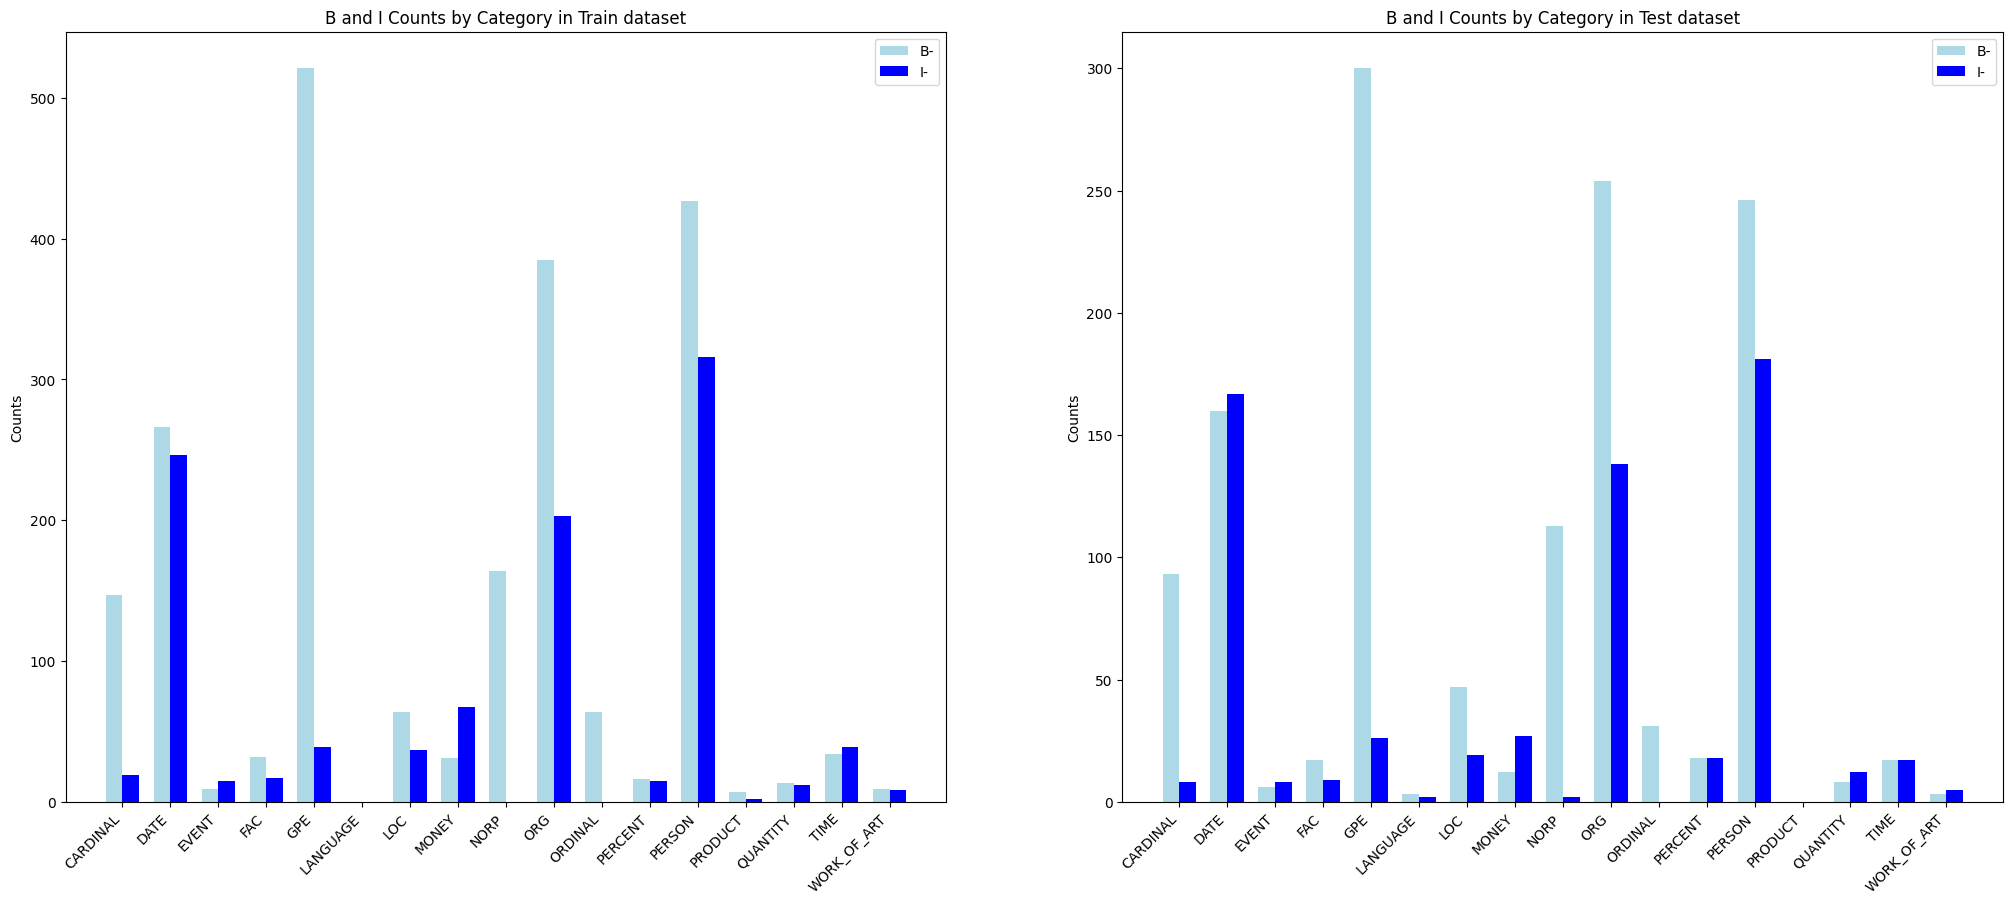

In [14]:
fig, axes = plt.subplots(1,2, figsize=(25,10))

datasets = [train_starts, test_starts]
titles = ['Train', 'Test']
for i, ax in enumerate(axes):
    categories = list(datasets[i].keys())
    B_values = [datasets[i][cat]['B'] for cat in categories]
    I_values = [datasets[i][cat]['I'] for cat in categories]
    width = 0.35
    x = np.arange(len(categories))
    rects1 = ax.bar(x - width/2, B_values, width, label='B-', color='lightblue')
    rects2 = ax.bar(x + width/2, I_values, width, label='I-', color='blue')
    ax.set_ylabel('Counts')
    ax.set_title(f'B and I Counts by Category in {titles[i]} dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()
plt.show()

According to the bar chart above, classes 'Date', 'ORG', 'Person' in both train and test datasets contain more than 2 words, while 'Cardinal', 'GPE', 'NORP' usually contain 1 word

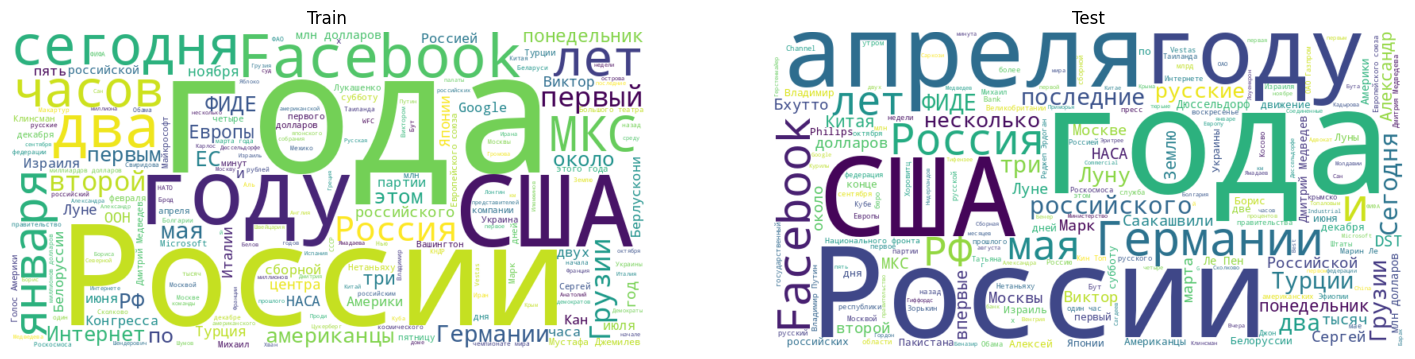

In [15]:
datasets = [train, test]
titles = ['Train', 'Test']
fig, axes = plt.subplots(1, len(datasets), figsize=(18,6))
for i in range(len(datasets)):
    text = " ".join([token for sentence in datasets[i] for token, label in sentence if label != 'O'])

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(titles[i])
plt.show()

Most common words in train datasets are:
  - Года and its forms
  - Россия
  - США
  - Facebook
Most common words in test datasets are:
  - Года and its forms
  - Россия
  - США
  - Facebook

It means that such words are widely used in news .....

# Rule-based approach

In [ ]:
import spacy
from spacy.pipeline import EntityRuler

rule_based_model = spacy.load('ru_core_news_md')

ruler = rule_based_model.add_pipe("entity_ruler", before="ner")

# Define patterns
patterns = [
    {"label": "ORDINAL", "pattern": [{"LOWER": {"REGEX": "^(первый|второй|третий|четвёртый|пятый|шестой|седьмой|восьмой|девятый|нулевой)$"}}]},
    {"label": "ORDINAL", "pattern": [{"TEXT": {"REGEX": "^\\d+-й$"}}]},
    {"label": "CARDINAL", "pattern": [{"TEXT": {"REGEX": "^\\d+$"}}]},
    {"label": "DATE", "pattern": [{"TEXT": {"REGEX": "\\d{2}\\.\\d{2}\\.\\d{4}"}}]},
    {"label": "DATE", "pattern": [{"TEXT": {"REGEX": "\\d{1,2} \\w+ \\d{4}"}}]},
    {"label": "EVENT", "pattern": [{"LOWER": {"IN": ["Новогодние каникулы", "Рождество Христово", 
                                                     "День защитника Отечества", "Международный женский день",
                                                     "Праздник Весны и Труда", "День Победы", 
                                                     "День России", "День народного единства"]}}]},
    {"label": "FAC", "pattern": [{"TEXT": {"REGEX": "^[А-Я][а-я]+ский мост$"}}]},
    {"label": "FAC", "pattern": [{"TEXT": {"REGEX": "^[А-Я][а-я]+ская башня$"}}]},
    {"label": "GPE", "pattern": [{"TEXT": {"REGEX": "США|Росси[а-я]+|Япони[а-я]+|Москв[а-я]+|Грузи[а-я]+|ЕС"}}]},
    {"label": "LANGUAGE", "pattern": [{"LOWER": {"IN": ["русский", "английский", "китайский", "французский", "японский"]}}]},
    {"label": "LOC", "pattern": [{"TEXT": {"REGEX": "^[А-Я][а-я]+ (гор[а-я]*|рек[а-я]|озер[а-я])$"}}]},
    {"label": "LOC", "pattern": [{"TEXT": {"REGEX": "^река [А-Я][а-я]+$"}}]},
    {"label": "MONEY", "pattern": [{"TEXT": {"REGEX": "^\\d+ руб\\.$"}}]},
    {"label": "MONEY", "pattern": [{"TEXT": {"REGEX": "^\\d+\\s+₽$"}}]},
    {"label": "NORP", "pattern": [{"LOWER": {"IN": ["русский", "немец", "еврей",
                                                    "грузин", "японец", "русская",
                                                    "немка", "еврейка", "грузинка",
                                                    "японка", "православный", "мусульманин",
                                                    "православная", "мусульманка"]}}]},
    {"label": "ORG", "pattern": [{"TEXT": {"REGEX": "^[А-Я][а-я]+[-]*банк$"}}]},
    {"label": "ORG", "pattern": [{"LOWER": {"IN": ["газпром", "яндекс", "озон", "магнит", "пятерочка"]}}]},
    {"label": "PERCENT", "pattern": [{"TEXT": {"REGEX": "^\\d+%$"}}]},
    {"label": "PERCENT", "pattern": [{"TEXT": {"REGEX": "^\\d+ проц\\.$"}}]},
    {"label": "PERSON", "pattern": [{"TEXT": {"REGEX": "^[А-ЯЁ][а-яё]+ [А-ЯЁ][а-яё]+$"}}]},
    {"label": "PERSON", "pattern": [{"TEXT": {"REGEX": "^(г-н|г-жа|тов\\.)? ?[А-ЯЁ][а-яё]+ [А-ЯЁ][а-яё]+$"}}]},
    {"label": "PERSON", "pattern": [{"TEXT": {"REGEX": "^[А-ЯЁ][а-яё]+ [А-ЯЁ][а-яё]+( [А-ЯЁ][а-яё]+)?$"}}]},
    {"label": "PRODUCT", "pattern": [{"TEXT": {"REGEX": "^[А-Я][а-я]+фон$"}}]},
    {"label": "PRODUCT", "pattern": [{"TEXT": {"REGEX": "^[А-Я][а-я]+ный товар$"}}]},
    {"label": "QUANTITY", "pattern": [{"TEXT": {"REGEX": "^\\d+ [к|м]*г$"}}]},
    {"label": "QUANTITY", "pattern": [{"TEXT": {"REGEX": "^\\d+ [милли]*литров$"}}]},
    {"label": "TIME", "pattern": [{"TEXT": {"REGEX": "^\\d+:\\d+$"}}]},
    {"label": "TIME", "pattern": [{"TEXT": {"REGEX": "^\\d+ [секунд|минут|часов]$"}}]},
    {"label": "WORK_OF_ART", "pattern": [{"TEXT": {"REGEX": "^[«\"]\\w+[»\"]$"}}]},
    {"label": "WORK_OF_ART", "pattern": [{"TEXT": {"REGEX": "^[А-Я][а-я]+ \\w+$"}}]},
]

ruler.add_patterns(patterns)

In [79]:
from spacy import displacy
doc = rule_based_model(' '.join([i[0] for i in test[20]]))

for ent in doc.ents:
    print(f"{ent.text}: {ent.label_}")

displacy.render(doc, style="ent", jupyter=True)

Китае: LOC
Кубе: LOC
Эритрее: LOC
Эфиопии: LOC


In [18]:
mapping = {
    'B-CARDINAL' : 'CARDINAL',
    'B-DATE' : 'DATE',
    'B-EVENT' : 'EVENT',
    'B-FAC' : 'FAC',
    'B-GPE' : 'GPE',
    'B-LANGUAGE' : 'LANGUAGE',
    'B-LOC' : 'LOC',
    'B-MONEY' : 'MONEY',
    'B-NORP' : 'NORP',
    'B-ORDINAL' : 'ORDINAL',
    'B-ORG' : 'ORG',
    'B-PERCENT' : 'PERCENT',
    'B-PERSON' : 'PER',
    'B-PRODUCT' : 'PRODUCT',
    'B-QUANTITY' : 'QUANTITY',
    'B-TIME' : 'TIME',
    'B-WORK_OF_ART' : 'WORK_OF_ART',
    'I-CARDINAL' : 'CARDINAL',
    'I-DATE' : 'DATE',
    'I-EVENT' : 'EVENT',
    'I-FAC' : 'FAC',
    'I-GPE' : 'GPE',
    'I-LANGUAGE' : 'LANGUAGE',
    'I-LOC' : 'LOC',
    'I-MONEY' : 'MONEY',
    'I-NORP' : 'NORP',
    'I-ORG' : 'ORG',
    'I-PERCENT' : 'PERCENT',
    'I-PERSON' : 'PER',
    'I-PRODUCT' : 'PRODUCT',
    'I-QUANTITY' : 'QUANTITY',
    'I-TIME' : 'TIME',
    'I-WORK_OF_ART' : 'WORK_OF_ART',
    'O' : 'O'
}

In [19]:
from tqdm import tqdm

def calculate_metrics(data, model):
    metrics = {
        'accuracy' : 0,
        'precision' : 0,
        'recall' : 0,
        'f1_macro' : 0
    }
    all_y_true = []
    all_y_pred = []
    for sentence in tqdm(data):
        # print(data)
        model_resp = model(' '.join(word[0] for word in sentence))
        y_pred = []
        y_true = []
        for token in model_resp:
            y_pred.append(token.ent_type_ if token.ent_type_ else 'O')
        for word in sentence:
            y_true.append(mapping[word[1]])
        if len(y_true) != len(y_pred):
            continue
        all_y_true.extend(y_true)
        all_y_pred.extend(y_pred)
    print(len(all_y_pred), len(all_y_true))
    metrics['accuracy'] = accuracy_score(all_y_true, all_y_pred)
    metrics['precision'] = precision_score(all_y_true, all_y_pred, average='macro')
    metrics['recall'] = recall_score(all_y_true, all_y_pred, average='macro')
    metrics['f1_macro'] = f1_score(all_y_true, all_y_pred, average='macro')
    return metrics

In [20]:
metrics = calculate_metrics(test, rule_based_model)
metrics

100%|██████████| 530/530 [00:03<00:00, 148.28it/s]

9665 9665



/home/habkaffee/programming/nlp/lab_2/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.8952922917744439,
 'precision': 0.2723796846138175,
 'recall': 0.2722591823479864,
 'f1_macro': 0.24186610639431502}

This metrics show that rule based approach not really good, because accuracy is not really representative. This approach also one of the hardest, because we need to know the target language really well in order to provide correct regex for each case.

# NN Approach

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

parsed_data, tags = parse_dataset_to_sentences('data/rus.tsv')
sentences, labels = [[word[0] for word in sentence] for sentence in parsed_data], [[mapping[word[1]] for word in sentence] for sentence in parsed_data]

word2idx = {"<PAD>": 0, "<UNK>": 1}
label2idx = {'O': 0}

for sentence in sentences:
    for word in sentence:
        if word not in word2idx:
            word2idx[word] = len(word2idx)

for label_seq in labels:
    for label in label_seq:
        if label not in label2idx:
            label2idx[label] = len(label2idx)

idx2label = {v: k for k, v in label2idx.items()}

In [ ]:
def encode_sentences(sentences, word2idx):
    return [[word2idx.get(word, word2idx["<UNK>"]) for word in sentence] for sentence in sentences]

def encode_labels(labels, label2idx):
    return [[label2idx[label] for label in label_seq] for label_seq in labels]

X = encode_sentences(sentences, word2idx)
# X_char = encode_by_chars(sentences, char2idx)
y = encode_labels(labels, label2idx)

def pad_sequences(sequences, pad_value):
    max_len = max(len(seq) for seq in sequences)
    return [seq + [pad_value] * (max_len - len(seq)) for seq in sequences]

X = pad_sequences(X, word2idx["<PAD>"])
y = pad_sequences(y, label2idx["O"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

X_train, X_test = torch.tensor(X_train, dtype=torch.long), torch.tensor(X_test, dtype=torch.long)
y_train, y_test = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_test, dtype=torch.long)

In [23]:
class NERDataset(Dataset):
    def __init__(self, sentences, labels):
        self.sentences = sentences
        self.labels = labels

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.sentences[idx], self.labels[idx]

train_dataset = NERDataset(X_train, y_train)
test_dataset = NERDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchcrf import CRF

class BiLSTMNER(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=128, hidden_dim=256):
        super(BiLSTMNER, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.dropout = nn.Dropout(0.5)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)
        self.crf = CRF(tagset_size, batch_first=True)

    def forward(self, sentences, tags=None):
        embedded = self.embedding(sentences)  # (batch_size, seq_len, embedding_dim)
        embedded = self.dropout(embedded) 
        lstm_out, _ = self.lstm(embedded)  # (batch_size, seq_len, hidden_dim)
        
        emissions = self.fc(lstm_out)  # (batch_size, seq_len, tagset_size)
        
        if tags is not None:
            mask = sentences.ne(0).byte()  # Create mask for padding
            return -self.crf(emissions, tags, mask=mask)
        else:
            # During inference, when tags are not provided
            return self.crf.decode(emissions)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BiLSTMNER(vocab_size=len(word2idx), tagset_size=len(label2idx)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for sentences, labels in train_loader:
            sentences, labels = sentences.to(device), labels.to(device)
            optimizer.zero_grad()
            
            loss = model(sentences, labels)
            total_loss += loss.item()
            
            # Backward pass
            loss.backward()
            optimizer.step()
        
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")



In [ ]:
train_model(model, train_loader, optimizer, num_epochs=75)

Epoch 1, Loss: 1349.4171044921875
Epoch 2, Loss: 640.2936938476563
Epoch 3, Loss: 577.0289807128906
Epoch 4, Loss: 556.3438549804688
Epoch 5, Loss: 538.96232421875
Epoch 6, Loss: 521.6425756835938
Epoch 7, Loss: 497.7872204589844
Epoch 8, Loss: 475.9148254394531
Epoch 9, Loss: 451.2541076660156
Epoch 10, Loss: 430.19523193359373
Epoch 11, Loss: 407.8039892578125
Epoch 12, Loss: 390.00464599609376
Epoch 13, Loss: 367.8262036132812
Epoch 14, Loss: 349.4313427734375
Epoch 15, Loss: 334.7337854003906
Epoch 16, Loss: 320.4004156494141
Epoch 17, Loss: 300.8931140136719
Epoch 18, Loss: 287.03106079101565
Epoch 19, Loss: 268.1957696533203
Epoch 20, Loss: 259.60290283203125
Epoch 21, Loss: 248.42351318359374
Epoch 22, Loss: 237.26296142578124
Epoch 23, Loss: 229.47190307617188
Epoch 24, Loss: 218.04360229492187
Epoch 25, Loss: 205.57430053710937
Epoch 26, Loss: 193.9023303222656
Epoch 27, Loss: 188.08710235595703
Epoch 28, Loss: 179.26702453613282
Epoch 29, Loss: 171.743720703125
Epoch 30, Loss

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

def evaluate_model(model, test_loader, idx2label):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for sentences, labels in test_loader:
            sentences = sentences.to(device)
            labels = labels.to(device)
            
            # Get predicted labels
            predictions = model(sentences)  # This now returns the best tag sequence
            
            # Convert predictions to tensor and move to the same device as labels
            predictions = torch.tensor(predictions, device=device)
            
            # Ignore padding
            mask = labels != word2idx["<PAD>"]
            
            all_predictions.extend(predictions[mask].cpu().numpy())
            all_labels.extend(labels[mask].cpu().numpy())

    # Convert numeric labels to string labels
    all_predictions = [idx2label[pred] for pred in all_predictions]
    all_labels = [idx2label[label] for label in all_labels]

    # Calculate overall metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')

    print(f"Overall Metrics:")
    print(f'Accuracy: {accuracy:.4f}')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Calculate metrics for each entity type
    labels = list(set(all_labels) - set(['O']))
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, labels=labels, average=None)

    print("\nMetrics by Entity Type:")
    for label, p, r, f in zip(labels, precision, recall, f1):
        print(f"{label}:")
        print(f"  Precision: {p:.4f}")
        print(f"  Recall: {r:.4f}")
        print(f"  F1-score: {f:.4f}")

    return precision, recall, f1

precision, recall, f1 = evaluate_model(model, test_loader, idx2label)


Overall Metrics:
Accuracy: 0.4965
Precision: 0.8337
Recall: 0.4965
F1-score: 0.6110

Metrics by Entity Type:
EVENT:
  Precision: 0.8571
  Recall: 0.4615
  F1-score: 0.6000
TIME:
  Precision: 0.5000
  Recall: 0.1429
  F1-score: 0.2222
WORK_OF_ART:
  Precision: 0.0000
  Recall: 0.0000
  F1-score: 0.0000
QUANTITY:
  Precision: 0.0000
  Recall: 0.0000
  F1-score: 0.0000
PRODUCT:
  Precision: 0.0000
  Recall: 0.0000
  F1-score: 0.0000
PERCENT:
  Precision: 1.0000
  Recall: 0.7188
  F1-score: 0.8364
GPE:
  Precision: 0.7985
  Recall: 0.6325
  F1-score: 0.7059
DATE:
  Precision: 0.9574
  Recall: 0.7462
  F1-score: 0.8387
LOC:
  Precision: 0.5294
  Recall: 0.3103
  F1-score: 0.3913
PER:
  Precision: 0.8951
  Recall: 0.5053
  F1-score: 0.6459
NORP:
  Precision: 0.8333
  Recall: 0.2991
  F1-score: 0.4403
FAC:
  Precision: 0.7778
  Recall: 0.2059
  F1-score: 0.3256
ORG:
  Precision: 0.8333
  Recall: 0.3342
  F1-score: 0.4771
ORDINAL:
  Precision: 0.9412
  Recall: 0.4000
  F1-score: 0.5614
LANGUAG

/home/habkaffee/programming/nlp/lab_2/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/habkaffee/programming/nlp/lab_2/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/habkaffee/programming/nlp/lab_2/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{

In [80]:
def predict(model, sentence, word2idx, idx2label):
    model.eval()
    tokens = [word2idx.get(word, word2idx["<UNK>"]) for word in sentence]
    tokens_tensor = torch.tensor([tokens], dtype=torch.long).to(device)

    with torch.no_grad():
        predictions = model(tokens_tensor)  # This now returns the best tag sequence
        # predictions is already a list, so we don't need to use .squeeze().tolist()

    return [(word, idx2label[pred]) for word, pred in zip(sentence, predictions[0])]

# Test the model
test_sentence = [i[0] for i in test[1]]
result = predict(model, test_sentence, word2idx, idx2label)
result


[('В', 'O'),
 ('последних', 'O'),
 ('играх', 'O'),
 ('сборной', 'ORG'),
 (',', 'O'),
 ('Клинсман', 'PER'),
 ('придерживался', 'O'),
 ('принципа', 'O'),
 ('очерёдности', 'O'),
 ('вратарей', 'O'),
 (',', 'O'),
 ('что', 'O'),
 ('привело', 'O'),
 ('к', 'O'),
 ('привело', 'O'),
 ('к', 'O'),
 ('бескомпромиссной', 'O'),
 ('борьбе', 'O'),
 ('между', 'O'),
 ('Леманом', 'PER'),
 ('и', 'O'),
 ('Каном', 'PER'),
 ('за', 'O'),
 ('вратарский', 'O'),
 ('пост', 'O'),
 ('на', 'O'),
 ('предстоящем', 'O'),
 ('чемпионате', 'EVENT'),
 ('мира', 'EVENT'),
 ('.', 'O')]

Neural network performs way better than rule-based approach.